In [1]:
import torch
import torch.nn as nn
import nltk

In [3]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [6]:
input_size = 5
hidden_size = 8

inputs = torch.Tensor(1, 10, 5)

cell = nn.RNN(input_size, hidden_size, num_layers=2, batch_first=True)
outputs, _status = cell(inputs)

print(outputs.shape)
print(_status.shape)

torch.Size([1, 10, 8])
torch.Size([2, 1, 8])


In [7]:
input_size = 5
hidden_size = 8

inputs = torch.Tensor(1, 10, 5)

cell = nn.RNN(input_size, hidden_size, num_layers=2, batch_first=True, bidirectional=True)
outputs, _status = cell(inputs)

print(outputs.shape)
print(_status.shape)

torch.Size([1, 10, 16])
torch.Size([4, 1, 8])


In [10]:
input_size = 5
hidden_size = 8

inputs = torch.Tensor(1, 10, 5)

cell = nn.LSTM(input_size, hidden_size, num_layers=2, batch_first=True, bidirectional=True)
outputs, _status = cell(inputs)

print(outputs.shape)
print(_status[0].shape)

torch.Size([1, 10, 16])
torch.Size([4, 1, 8])


In [2]:
import torch.optim as optim
import numpy as np

In [12]:
input_str = 'apple'
label_str = 'pple!'
char_vocab = sorted(list(set(input_str+label_str)))
vocab_size = len(char_vocab)
print ('문자 집합의 크기 : {}'.format(vocab_size))

문자 집합의 크기 : 5


In [14]:
char_vocab

['!', 'a', 'e', 'l', 'p']

In [13]:
input_size = vocab_size # 입력의 크기는 문자 집합의 크기
hidden_size = 5
output_size = 5
learning_rate = 0.1

In [16]:
char_to_index = dict((c, i) for i, c in enumerate(char_vocab))
print(char_to_index)
index_to_char = {}
for key, value in char_to_index.items():
    index_to_char[value] = key

{'!': 0, 'a': 1, 'e': 2, 'l': 3, 'p': 4}


In [23]:
x_data = [char_to_index[c] for c in input_str]
y_data = [char_to_index[c] for c in label_str]
x_data = [x_data]
y_data = [y_data]
print(x_data)
print(y_data)
x_one_hot = np.array([np.eye(vocab_size)[x] for x in x_data])
print(x_one_hot)

[[1, 4, 4, 3, 2]]
[[4, 4, 3, 2, 0]]
[[[0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 1.]
  [0. 0. 0. 1. 0.]
  [0. 0. 1. 0. 0.]]]


In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
X = torch.FloatTensor(x_one_hot).to(device)
Y = torch.LongTensor(y_data).to(device)

cuda


In [39]:
class Net(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.rnn = torch.nn.RNN(input_size, hidden_size, batch_first=True) # RNN 셀 구현
        self.fc = torch.nn.Linear(hidden_size, output_size, bias=True) # 출력층 구현

    def forward(self, x): # 구현한 RNN 셀과 출력층을 연결
        x, _status = self.rnn(x)
        x = self.fc(x)
        return x

In [40]:
import torchsummary


net = Net(input_size, hidden_size, output_size).to(device)
torchsummary.summary(net, input_size=(1, input_size), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               RNN-1   [[-1, 1, 5], [-1, 2, 5]]               0
            Linear-2                 [-1, 1, 5]              30
Total params: 30
Trainable params: 30
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [42]:
outputs = net(X)
print(outputs.view(-1, input_size).shape)
print(Y.shape)
print(Y.view(-1).shape)

torch.Size([5, 5])
torch.Size([1, 5])
torch.Size([5])


In [43]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), learning_rate)

In [47]:
for i in range(100):
    optimizer.zero_grad()
    outputs = net(X)
    loss = criterion(outputs.view(-1, input_size), Y.view(-1)) # view를 하는 이유는 Batch 차원 제거를 위해
    loss.backward() # 기울기 계산
    optimizer.step() # 아까 optimizer 선언 시 넣어둔 파라미터 업데이트

    # 아래 세 줄은 모델이 실제 어떻게 예측했는지를 확인하기 위한 코드.
    result = outputs.data.argmax(axis=2) # 최종 예측값인 각 time-step 별 5차원 벡터에 대해서 가장 높은 값의 인덱스를 선택
    result_str = ''.join([index_to_char[c.item()] for c in np.squeeze(result)])
    print(i, "loss: ", loss.item(), "prediction: ", result, "true Y: ", y_data, "prediction str: ", result_str)

0 loss:  1.1513410806655884 prediction:  tensor([[4, 4, 3, 4, 0]], device='cuda:0') true Y:  [[4, 4, 3, 2, 0]] prediction str:  pplp!
1 loss:  0.9466041326522827 prediction:  tensor([[4, 4, 3, 4, 0]], device='cuda:0') true Y:  [[4, 4, 3, 2, 0]] prediction str:  pplp!
2 loss:  0.7849953770637512 prediction:  tensor([[4, 4, 3, 4, 0]], device='cuda:0') true Y:  [[4, 4, 3, 2, 0]] prediction str:  pplp!
3 loss:  0.6621822118759155 prediction:  tensor([[4, 4, 3, 4, 0]], device='cuda:0') true Y:  [[4, 4, 3, 2, 0]] prediction str:  pplp!
4 loss:  0.5500205159187317 prediction:  tensor([[4, 4, 3, 4, 0]], device='cuda:0') true Y:  [[4, 4, 3, 2, 0]] prediction str:  pplp!
5 loss:  0.45314115285873413 prediction:  tensor([[4, 4, 3, 4, 0]], device='cuda:0') true Y:  [[4, 4, 3, 2, 0]] prediction str:  pplp!
6 loss:  0.3795475959777832 prediction:  tensor([[4, 4, 3, 4, 0]], device='cuda:0') true Y:  [[4, 4, 3, 2, 0]] prediction str:  pplp!
7 loss:  0.31413987278938293 prediction:  tensor([[4, 4, 3, 2

78 loss:  0.0005720874178223312 prediction:  tensor([[4, 4, 3, 2, 0]], device='cuda:0') true Y:  [[4, 4, 3, 2, 0]] prediction str:  pple!
79 loss:  0.0005668463418260217 prediction:  tensor([[4, 4, 3, 2, 0]], device='cuda:0') true Y:  [[4, 4, 3, 2, 0]] prediction str:  pple!
80 loss:  0.0005617003771476448 prediction:  tensor([[4, 4, 3, 2, 0]], device='cuda:0') true Y:  [[4, 4, 3, 2, 0]] prediction str:  pple!
81 loss:  0.0005567451007664204 prediction:  tensor([[4, 4, 3, 2, 0]], device='cuda:0') true Y:  [[4, 4, 3, 2, 0]] prediction str:  pple!
82 loss:  0.0005518612451851368 prediction:  tensor([[4, 4, 3, 2, 0]], device='cuda:0') true Y:  [[4, 4, 3, 2, 0]] prediction str:  pple!
83 loss:  0.0005470725591294467 prediction:  tensor([[4, 4, 3, 2, 0]], device='cuda:0') true Y:  [[4, 4, 3, 2, 0]] prediction str:  pple!
84 loss:  0.0005424030241556466 prediction:  tensor([[4, 4, 3, 2, 0]], device='cuda:0') true Y:  [[4, 4, 3, 2, 0]] prediction str:  pple!
85 loss:  0.0005378049099817872 pr

In [3]:
sentence = ("if you want to build a ship, don't drum up people together to "
            "collect wood and don't assign them tasks and work, but rather "
            "teach them to long for the endless immensity of the sea.")

In [4]:
char_set = list(set(sentence))
char_dic = {c: i for i, c in enumerate(char_set)}
print(char_dic)

{'e': 0, 'n': 1, 'r': 2, 's': 3, ',': 4, 'i': 5, 'a': 6, 'w': 7, '.': 8, 'p': 9, 't': 10, 'h': 11, "'": 12, 'y': 13, 'c': 14, 'd': 15, 'm': 16, 'k': 17, 'f': 18, 'g': 19, ' ': 20, 'o': 21, 'u': 22, 'b': 23, 'l': 24}


In [5]:
hidden_size = len(char_dic)
sequence_length = 10
LR = 0.1
x_data = []
y_data = []

for i in range(0, len(sentence) - sequence_length):
    x_str = sentence[i:i+sequence_length]
    y_str = sentence[i+1:i+sequence_length+1]
    print(i, x_str, '->', y_str)
    x_data.append([char_dic[c] for c in x_str])  # x str to index
    y_data.append([char_dic[c] for c in y_str])  # y str to index

0 if you wan -> f you want
1 f you want ->  you want 
2  you want  -> you want t
3 you want t -> ou want to
4 ou want to -> u want to 
5 u want to  ->  want to b
6  want to b -> want to bu
7 want to bu -> ant to bui
8 ant to bui -> nt to buil
9 nt to buil -> t to build
10 t to build ->  to build 
11  to build  -> to build a
12 to build a -> o build a 
13 o build a  ->  build a s
14  build a s -> build a sh
15 build a sh -> uild a shi
16 uild a shi -> ild a ship
17 ild a ship -> ld a ship,
18 ld a ship, -> d a ship, 
19 d a ship,  ->  a ship, d
20  a ship, d -> a ship, do
21 a ship, do ->  ship, don
22  ship, don -> ship, don'
23 ship, don' -> hip, don't
24 hip, don't -> ip, don't 
25 ip, don't  -> p, don't d
26 p, don't d -> , don't dr
27 , don't dr ->  don't dru
28  don't dru -> don't drum
29 don't drum -> on't drum 
30 on't drum  -> n't drum u
31 n't drum u -> 't drum up
32 't drum up -> t drum up 
33 t drum up  ->  drum up p
34  drum up p -> drum up pe
35 drum up pe -> rum up peo
36

In [6]:
class Net(torch.nn.Module):
    def __init__(self, input_size, hidden_size, layers):
        super(Net, self).__init__()
        self.rnn = torch.nn.RNN(input_size, hidden_size, num_layers=layers, batch_first=True) # RNN 셀 구현
        self.fc = torch.nn.Linear(hidden_size, hidden_size, bias=True) # 출력층 구현

    def forward(self, x): # 구현한 RNN 셀과 출력층을 연결
        x, _status = self.rnn(x)
        x = self.fc(x)
        return x

In [7]:
net = Net(len(char_dic), hidden_size, 2)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), LR)

In [13]:
x_one_hot = np.array([np.eye(len(char_dic))[x] for x in x_data]) # x 데이터는 원-핫 인코딩
X = torch.FloatTensor(x_one_hot)
Y = torch.LongTensor(y_data)
outputs = net(X)

print(X.shape)
print(Y.shape)
print(outputs.shape)

torch.Size([170, 10, 25])
torch.Size([170, 10])
torch.Size([170, 10, 25])


In [15]:
print(outputs.view(-1, len(char_dic)).shape)

torch.Size([1700, 25])


In [11]:
for i in range(100):
    optimizer.zero_grad()
    outputs = net(X) # (170, 10, 25) 크기를 가진 텐서를 매 에포크마다 모델의 입력으로 사용
    loss = criterion(outputs.view(-1, len(char_dic)), Y.view(-1))
    loss.backward()
    optimizer.step()

    # results의 텐서 크기는 (170, 10)
    results = outputs.argmax(dim=2)
    predict_str = ""
    for j, result in enumerate(results):
        if j == 0: # 처음에는 예측 결과를 전부 가져오지만
            predict_str += ''.join([char_set[t] for t in result])
        else: # 그 다음에는 마지막 글자만 반복 추가
            predict_str += char_set[result[-1]]

    print(predict_str)

gfbbbbbbgbbbbbbbbgbbbbbbbggbbbbbgbbbbghbbgbbbbbbbbbbbbtbbbbbbbbbbbbbbbbbbbbgbgbgbbgbbbbbgbbbbbbbgbbbbbbgbgbbbbbbbbbbbbgbbbbbbbgbbbbbbbgtbbbbbbbbbbbtbbbbggbbbbbggggbgbbbbbbbtbbbbbg
tddd dd dd doddddddddddd d  dd dtodd d dt d  d oddodd dd dtoddoddttddd  ddttd dd dtodtddd ddod ddodd dddd d  dodddd d ddd dtoddt dtd ddoddt d d  dtod dtd d ddddddddddddd dtod dd d
        t                                                                                                       t                                                                  
ionffwf'nwos,osoon.dwos.o oswonw.oioohot.dl.dw.sw.ooofs.fswo ioswfs,o oolofohhoofnwos.shfsifhofoioshfs.osofsffwosotowfs,osl.oo.o oosootosifswosoos.o gsio fslfs.o ofdfsooow.os.dhfs
o tototoshttotl iototoiosl  o tttltttt iottttothltl ttlltlttlot ltlo ottottoiottthhhtt istototlttttototth tt th ttt totl tstotottthtt lt ot lttttlthittt lothtl  lo ltt tt ohiototh
t tht tht h h   h t t t t t t   ch   h uh  h t h  h   h    h  h t t   o     h     thah h    h    h h

tmyou want to build a ship, don't drum up people together to collect wood and don't assign them tasks and work, but rather teach them to long for the endless immensity of the sea.
tmyou want to build a ship, don't drum up people together to lollect wood and don't assign them tasks and work, but rather teach them to long for the endless immensity of the sea.
tmyou want to build a ship, don't drum up people together to collect wood and don't assign them tasks and work, but rather teach them to long for the endless immensity of the sea.
tmyou want to build a ship, don't drum up people together to collect wood and don't assign them tasks and work, but rather teach them to long for the endless immensity of the sea.
teyou want to build a ship, don't drum up people together to collect wood and don't assign them tasks and work, but rather teach them ta long for the endless immensity of the seac
teyou want to build a ship, don't drum up people together to collect wood and don't assign them task

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Mecab
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from collections import Counter

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x1654a7490>)

In [3]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력
print('테스트용 리뷰 개수 :',len(test_data)) # 테스트용 리뷰 개수 출력

훈련용 리뷰 개수 : 150000
테스트용 리뷰 개수 : 50000


In [4]:
train_data['document'].nunique(), train_data['label'].nunique()
train_data.drop_duplicates(subset=['document'], inplace=True)

<Axes: >

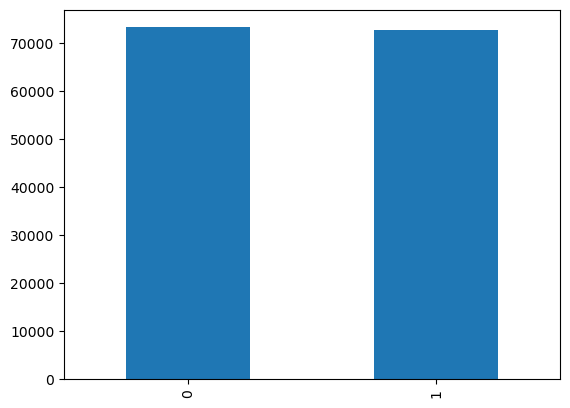

In [5]:
train_data['label'].value_counts().plot(kind = 'bar')

In [6]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  73342
1      1  72841


In [7]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:5]

/var/folders/x0/r3j93pws41712_dl1qyxtv7w0000gn/T/ipykernel_42771/2092559641.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [8]:
train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['document'].replace('', np.nan, inplace=True)
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48852


/var/folders/x0/r3j93pws41712_dl1qyxtv7w0000gn/T/ipykernel_42771/2642594262.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
/var/folders/x0/r3j93pws41712_dl1qyxtv7w0000gn/T/ipykernel_42771/2642594262.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
/var/folders/x0/r3j93pws41712_dl1qyxtv7w0000gn/T/ipykernel_42771/2642594262.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경


In [9]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']
mecab = Mecab()

Exception: Install MeCab in order to use it: http://konlpy.org/en/latest/install/